In [1]:
import numpy as np
from PIL import Image
import cv2
import csv
import os
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
folder = "../../data/strandvejen_faxe"
file_names = sorted(os.listdir(folder), key = lambda x: x[:4])
file_path = [folder + "/" + name for name in file_names]

In [3]:
model_output = pd.read_csv("../../output/custom/results/strandvejen_faxe.csv")

In [4]:
def get_img(img_path):
    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.resize(img, (512, 512))
    return img

def hist_eq(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

def print_img(img):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap='Greys_r')
    
def draw_bounding(img, x1, x2, y1, y2, label):
    # draw a rectangle on the image
    h, w = img.shape[:2]
    cv2.putText(img, label , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,12), 1)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)

In [5]:
model_output.head(20)

,1,1.1,416.2507629394531,882.741943359375,288.0049133300781,45.2806396484375,-1,-1.1,-1.2,-1.3
0,1,2,607.934753,725.428345,408.967651,296.025940,-1,-1,-1,-1
1,2,2,584.485718,716.717773,423.929810,297.843628,-1,-1,-1,-1
2,3,2,551.021790,699.421875,457.743591,319.499023,-1,-1,-1,-1
3,4,2,539.302551,679.198120,477.222961,343.576843,-1,-1,-1,-1
4,5,2,534.923096,670.799988,486.318298,353.116577,-1,-1,-1,-1
5,6,2,540.441833,673.800171,470.725952,352.199829,-1,-1,-1,-1
6,7,2,550.872620,680.782715,455.692505,345.217285,-1,-1,-1,-1
7,8,2,551.180542,686.518921,450.415466,339.481079,-1,-1,-1,-1
8,9,2,558.666870,691.431396,441.294495,334.568604,-1,-1,-1,-1
9,10,2,542.722107,679.607971,430.737000,346.392029,-1,-1,-1,-1


In [6]:
i = 100
one_frame = get_img(file_path[i])
frame_boxes_df = model_output[model_output["1"] == i]
frame_boxes_df

,1,1.1,416.2507629394531,882.741943359375,288.0049133300781,45.2806396484375,-1,-1.1,-1.2,-1.3
338,100,90,261.114258,808.896362,176.563202,184.385498,-1,-1,-1,-1
350,100,100,67.823563,761.568970,228.959000,187.554504,-1,-1,-1,-1
352,100,101,802.905579,954.318909,105.453796,71.217957,-1,-1,-1,-1
353,100,102,737.792297,874.253479,78.374878,66.738770,-1,-1,-1,-1
354,100,103,696.583130,830.133423,59.361511,47.499390,-1,-1,-1,-1


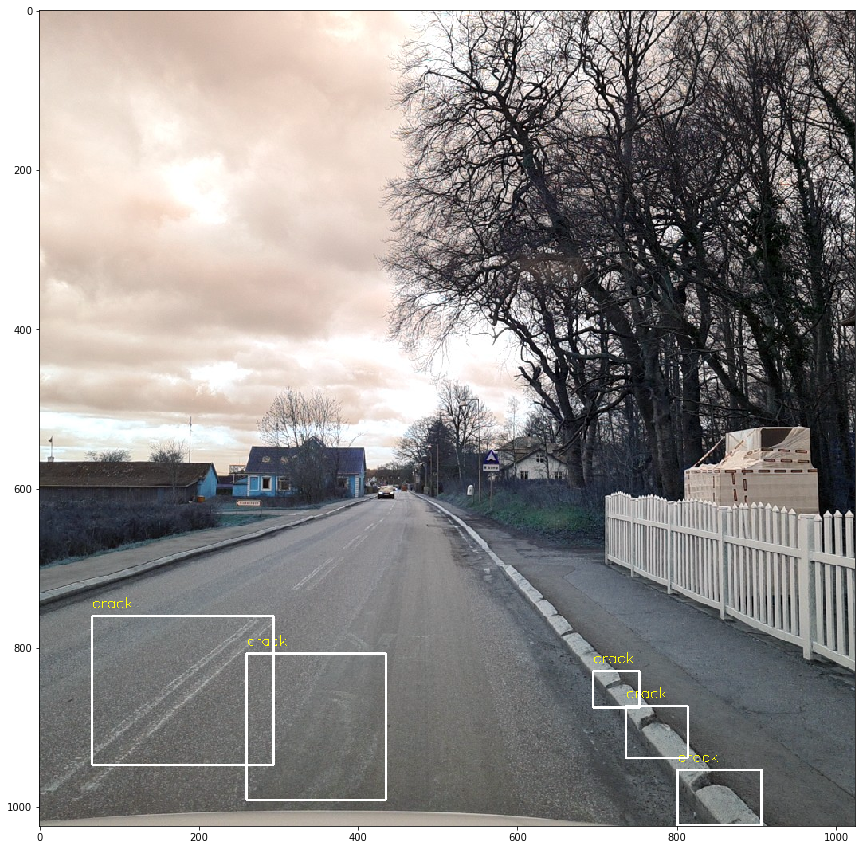

In [7]:
output_img = one_frame.copy()
for row in frame_boxes_df.values.tolist():
    x1 = float(row[2]) - 1
    y1 = float(row[3]) - 1
    x2 = float(row[4]) - 1 + x1
    y2 = float(row[5]) - 1 + y1
    draw_bounding(output_img, int(x1), int(x2), int(y1), int(y2), "crack")
print_img(output_img)

In [8]:
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter("tracktor_video.avi", fourcc, 30, (1024, 1024), True)
for i in range(100):
    one_frame = get_img(file_path[i])
    frame_boxes_df = model_output[model_output["1"] == i]
    output_img = one_frame.copy()
    for row in frame_boxes_df.values.tolist():
        x1 = float(row[2]) - 1
        y1 = float(row[3]) - 1
        x2 = float(row[4]) - 1 + x1
        y2 = float(row[5]) - 1 + y1
        draw_bounding(output_img, int(x1), int(x2), int(y1), int(y2), "Object " + str(row[1]))
    writer.write(output_img)
writer.release()


In [9]:
model_output["1"]

0        1
1        2
2        3
3        4
4        5
      ... 
350    100
351     99
352    100
353    100
354    100
Name: 1, Length: 355, dtype: int64